In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, binom, beta
from math import comb
import pymc3 as pm
import arviz as az

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
class MarkovChain:
    """A Markov chain with finitely many states.

    Attributes:
        A ((n,n) ndarray): the column-stochastic transition matrix for a
            Markov chain with n states.
        states (list(str)): a list of n labels corresponding to the n states.
            If not provided, the labels are the indices 0, 1, ..., n-1.\
        m: the integer dimension of A
        map: a dictionary mapping each label to its index
    """
    # Problem 1
    def __init__(self, A, states=None):
        """Check that A is column stochastic and construct a dictionary
        mapping a state's label to its index (the row / column of A that the
        state corresponds to). Save the transition matrix, the list of state
        labels, and the label-to-index dictionary as attributes.

        Parameters:
        A ((n,n) ndarray): the column-stochastic transition matrix for a
            Markov chain with n states.
        states (list(str)): a list of n labels corresponding to the n states.
            If not provided, the labels are the indices 0, 1, ..., n-1.

        Raises:
            ValueError: if A is not square or is not column stochastic.

        Example:
            >>> MarkovChain(np.array([[.5, .8], [.5, .2]], states=["A", "B"])
        corresponds to the Markov Chain with transition matrix
                                   from A  from B
                            to A [   .5      .8   ]
                            to B [   .5      .2   ]
        and the label-to-index dictionary is {"A":0, "B":1}.
        """
        self.m,self.n=np.shape(A) #size of matrix
        if self.m != self.n:      #make sure it's square
            raise ValueError("A is not square")
        for i in np.sum(A, axis=1): #make sure it's stochastic
            if round(i,2) != 1:
                raise ValueError("A is not column stochastic. Column sums are "+str(np.sum(A, axis=0)))
       
        indeces = np.arange(self.m)
        if states==None:
            self.labels = indeces
        else:
            if len(states) != self.m:
                raise ValueError("States is not the same length as the number of columns")
            self.labels = states
        
        self.map = {}
        for i in range(self.m):
            self.map[self.labels[i]]=i
            
        self.A = A

    def transition(self, state):
        """Transition to a new state by making a random draw from the outgoing
        probabilities of the state with the specified label.

        Parameters:
            state (str): the label for the current state.

        Returns:
            (str): the label of the state to transitioned to.
        """
        i = self.map[state]
        output = np.random.multinomial(1, self.A[:,i]) #Outputs a vector with just one 1 based on the probability of each entry
        k = np.argmax(output) #index of the 1
        return self.labels[k]
        
    def walk(self, start, N):
        """Starting at the specified state, use the transition() method to
        transition from state to state N-1 times, recording the state label at
        each step.

        Parameters:
            start (str): The starting state label.

        Returns:
            (list(str)): A list of N state labels, including start.
        """
        self.walk = [start]
        current = start
        for n in range(N-1): #Use transition to step through the matrix nodes
            current = self.transition(current)
            self.walk.append(current)
        
        return self.walk

# Problem 1

In [3]:
def bernoulli_sampling(p, n):
    """
    Simulate n tosses of a coin which gives heads with probability 
    p. Then use that sample to calculate the posterior distribution on 
    p given a uniform prior.

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate

    Returns:
        (float): The MAP estimate of p
    """
    nu = np.linspace(0,1,1000)
    X = np.random.binomial(n,p) 
    fx = [binom.pmf(X,n,i) for i in nu]
    fnu = np.sum(fx)
    posterior = fx/fnu
    plt.plot(nu,posterior)
    return nu[np.argmax(posterior)]

0.20020020020020018

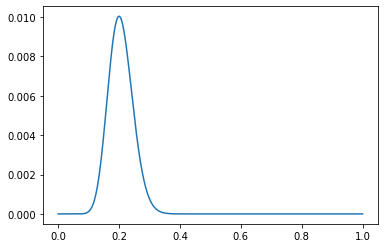

In [4]:
bernoulli_sampling(.2,100)

# Problem 2

In [5]:
def non_uniform_prior(p, n, prior):
    """
    Generate a sample of size n that has a Bernoulli
    distribution with a probability parameter p.
    Use Bayes' theorem to compute the posterior distribution
    for the given prior and the generated sample:
    
        P(t|x) = P(x|t) P(t) / P(x)
    
    Plot both prior and posterior distributions between [0, 1]

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate
        prior (scipy dist): the prior distribution on p

    Returns:
        (float): MAP estimate
    """
    nu = np.linspace(0,1,1000)
    X = np.random.binomial(n,p) 
    num = [binom.pmf(X,n,i)*prior.pdf(i) for i in nu]
    denom = np.sum(num)
    post = num/denom
    plt.plot(nu,post)
    return nu[np.argmax(post)]

0.24924924924924924

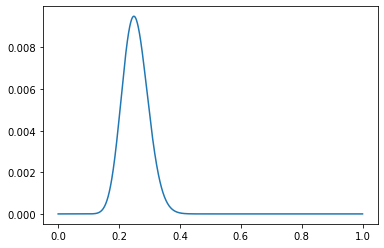

In [6]:
non_uniform_prior(.2, 100, beta(5,1.5))

# Problem 3

In [7]:
def weather_forecast(transition_matrix, days=10):
    """
    Given the above transition matrix and assuming the 0th day is sunny,
    sample from the markov chain to give a possible forecast of the 10 following
    days. 
    """
    chain = MarkovChain(transition_matrix, states = ['sun','rain','wind'])
    return chain.walk('sun',days)
    

In [8]:
transition_matrix = np.array(
  [
    [0.6,0.1,0.3],
    [0.2,0.6,0.2],
    [0.3,0.4,0.3]
  ]
)

In [9]:
weather_forecast(transition_matrix, days=10)

['sun', 'sun', 'sun', 'sun', 'rain', 'rain', 'rain', 'rain', 'sun', 'sun']

# Problem 4

In [29]:
def posterior_sampling(data, n=1000):
    """
    Given data that flips a coin 100 times, assume the data are distributed 
    as Bernoulli(p) for some unknown value of p, where p has a prior of 
    Beta(1,1). Set up a PyMC3 model for this situation and sample from the 
    poterior n times. Print a trace plot. Return the mean for the posterior.
    
    Parameters:
        data (array): The coin flips
        n (int): number of samples to take from the posterior
        
    Returns:
        Mean (float): The average of the coin flips (estimated p)
    """
    
    model = pm.Model()
    with model:
        p_val = pm.Beta('lambda', alpha=1, beta=1)
        y = pm.Bernoulli('y', p=p_val, observed = data)
        trace = pm.sample(n,return_inferencedata=False) #n is the desired number of samples
        az.plot_trace(trace)
        lam = trace['lambda']
        mean = lam.mean()
    return mean

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [lambda]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 20 seconds.


0.24627181538934004

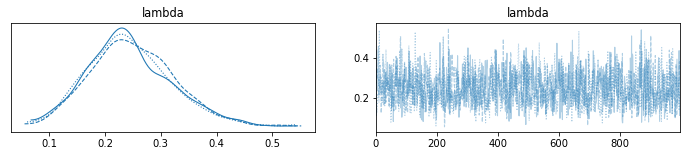

In [31]:
data = bernoulli.rvs(0.2, size=30)
posterior_sampling(data, n = 1000)

# Problem 5

In [32]:
def height_model(observed_heights,m=180,s=10,alpha=2,beta=10,n=1000):

    """
    Given a dataset of the measured heights of 100 men, assume the data are
    distributed as Normal(mu,1/tau) where mu has a prior of Normal(m,s), and tau has
    a prior of Gamma(alpha,beta). Set up a PyMC3 model for this situation and sample 
    from the poterior n times. Print a trace plot for mu and tau. Return the mean 
    for the posterior of mu.
    
    Parameters:
        observed_heights (array): The measured heights of 100 men
        m (int): the mean in the prior distribution of mu
        s (int): the standard deviation in the prior distribution of mu
        alpha (int): the first component in the prior distibution of tau
        beta (int): the second component in the prior distribution of tau
        n (int): number of samples from the posterior
        
    Returns:
        mu_mean (float): the estimated value of mu
    """
    model = pm.Model()
    with model:
        mu = pm.Normal('mu', m, s)
        tau = pm.Gamma('tau', alpha, beta)
        
        p = pm.Normal('p',mu, 1/tau, observed = observed_heights)
        
        trace = pm.sample(n,return_inferencedata=False) #n is the desired number of samples
        
        az.plot_trace(trace)
        mu = trace['mu']
        tau = trace['tau']
        mean = lam.mean()
    return mean
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\magic\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\magic\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\magic\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [tau, mu]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 75 seconds.
The acceptance probability does not match the target. It is 0.8822047764610113, but should be close to 0.8. Try to increase the number of tuning steps.


mean

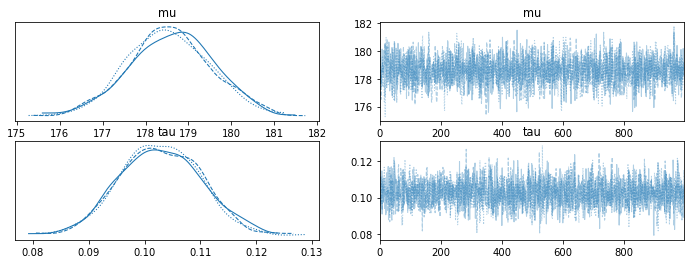

In [34]:
height_model(np.random.normal(180,10,100))